<a href="https://colab.research.google.com/github/LukeHaberkamp/AnomalyDetection/blob/main/GenerateTrainFluctuationDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
np.random.seed(42)

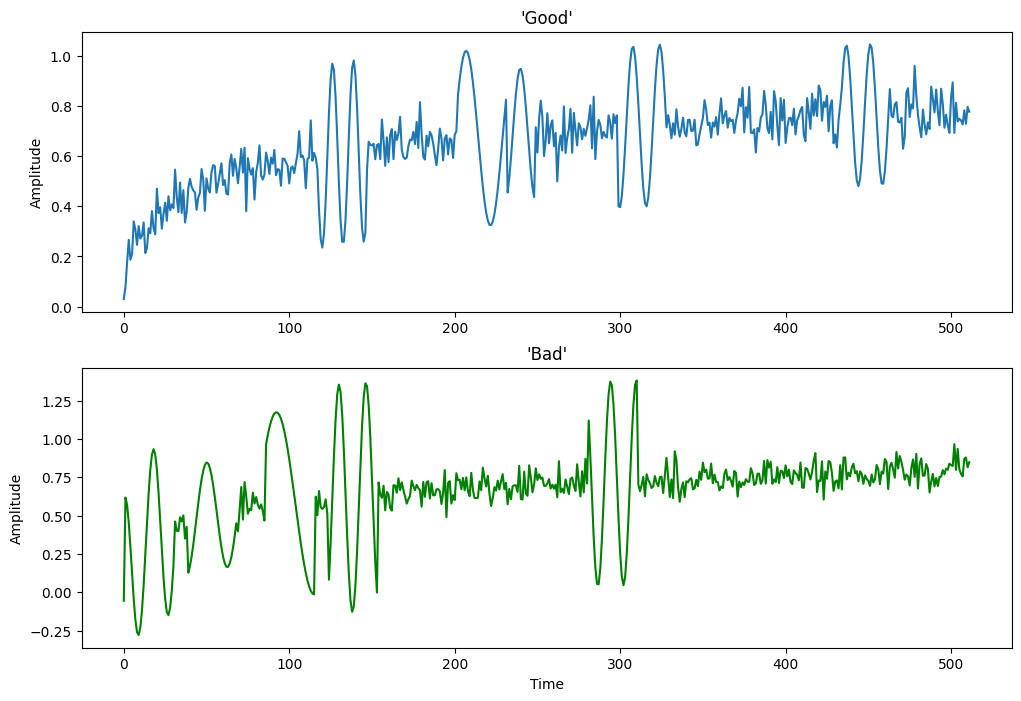

In [4]:
# time-axis
t = np.arange(512)
# Adjusting the first signal to include a logarithmic trend
trend = 10 + np.log1p(t)

def create_signal(t, trend, peak_amp):

    # Adding the trend to the first signal
    noise = np.random.normal(0, 0.5*np.std(trend), trend.shape[0])

    sig1 = noise + trend

    num_segments = 5
    window_size = 30
    sig3 = np.copy(sig1)
    for _ in range(num_segments):
        random_amp = np.random.uniform(2,peak_amp)
        random_freq = np.random.uniform(0.5,.1)
        sig2 = (np.cos(random_freq * t) * random_amp) + trend

        j = np.random.randint(window_size, len(t))
        sig3[j-window_size:j] = sig2[j-window_size:j]
    return (sig3 - 10) / 8

y1 = create_signal(t=t, trend=trend, peak_amp=3)
y2 = create_signal(t=t, trend=trend, peak_amp=6)

plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(t, y1)
plt.ylabel("Amplitude")
plt.title("'Good'")

plt.subplot(2, 1, 2)
plt.plot(t, y2, color='g')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("'Bad'")

plt.show()

In [5]:
# time-axis
t = np.arange(512)
# Adjusting the first signal to include a logarithmic trend
trend = 10 + np.log1p(t)

good_data = []
for i in range(20000):
    good_data.append(create_signal(t=t, trend=trend, peak_amp=3))
good_data = np.expand_dims(good_data, axis=2)

good_data_train = good_data[:16000]
good_data_val = good_data[16000:]

bad_data_val = []
for i in range(4000):
    bad_data_val.append(create_signal(t=t, trend=trend, peak_amp=6))
bad_data_val = np.expand_dims(bad_data_val, axis=2)

print("Good Data Train Shape:", good_data_train.shape)
print("Good Data Val Shape:", good_data_val.shape)
print("Bad Data Val Shape:", bad_data_val.shape)


np.save('./drive/My Drive/AutoencoderDetection/Data/good_data_train.npy', good_data_train)
np.save('./drive/My Drive/AutoencoderDetection/Data/good_data_val.npy', good_data_val)
np.save('./drive/My Drive/AutoencoderDetection/Data/bad_data_val.npy', bad_data_val)

Good Data Train Shape: (16000, 512, 1)
Good Data Val Shape: (4000, 512, 1)
Bad Data Val Shape: (4000, 512, 1)


In [6]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [7]:
# Build Model
inputs = Input(shape=(None, 1))

x = Conv1D(32, kernel_size=7, padding='same', activation='relu')(inputs) # Out=512

x = LayerNormalization()(x)
x = Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x) # Out=256

x = LayerNormalization()(x)
x = Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x) # Out=128

x = LayerNormalization()(x)
x = Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x) # Out=64

x = LayerNormalization()(x)
x = Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x) # Out=32

res = UpSampling1D(16)(x) # Out = 512

dilation_rates = [1, 2, 4, 8, 16, 32, 64, 128]
for dilation in reversed(dilation_rates):
    x = LayerNormalization()(res)
    x = Conv1D(64, kernel_size=3, dilation_rate=dilation, padding='same', activation='relu')(x)

    x = LayerNormalization()(x)
    x = Conv1D(64, kernel_size=3, dilation_rate=dilation, padding='same', activation='relu')(x)
    res = Add()([x, res])

x = LayerNormalization()(res)
outputs = Conv1D(1, kernel_size=1, padding='same')(x)

model = Model(inputs, outputs)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, None, 32)             256       ['input_1[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, None, 32)             64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, None, 64)             6208      ['layer_normalization[0][0

In [8]:
optimizer = Adam(learning_rate=1e-3)
loss = 'mse'
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(loss=loss, optimizer=optimizer)


In [9]:
history = model.fit(good_data_train,good_data_train,
            validation_data=(good_data_val,good_data_val),
            epochs=100,
            shuffle=True,
            batch_size=32,
            verbose=1,
            callbacks=[early_stopping])

Epoch 1/100
500/500 [==============================] - 47s 57ms/step - loss: 0.0811 - val_loss: 0.0127
Epoch 2/100
500/500 [==============================] - 28s 56ms/step - loss: 0.0105 - val_loss: 0.0091
Epoch 3/100
500/500 [==============================] - 28s 57ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 4/100
500/500 [==============================] - 28s 55ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 5/100
500/500 [==============================] - 28s 55ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 6/100
500/500 [==============================] - 28s 56ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 7/100
500/500 [==============================] - 28s 56ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 8/100
500/500 [==============================] - 28s 56ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 9/100
500/500 [==============================] - 28s 56ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 10/100
500/500 [==============================] - 28s 56ms/step - l

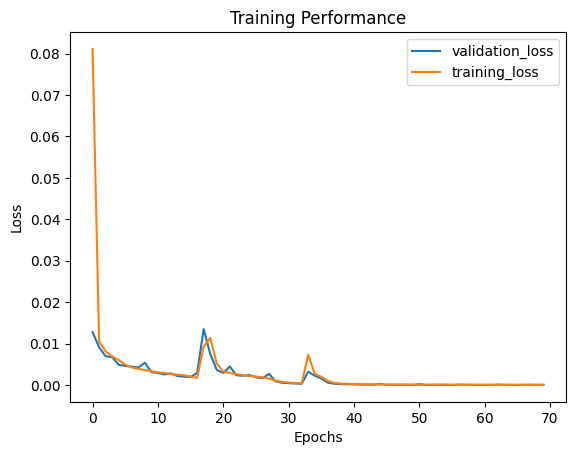

In [10]:
val_loss = history.history['val_loss']
loss = history.history['loss']

# Obtain number of epochs
epochs = range(len(loss))
# Plot loss and val loss
plt.plot(val_loss, label='validation_loss')
plt.plot(loss, label='training_loss')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [11]:
model.save('./drive/My Drive/AutoencoderDetection/AutoencoderModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
